# HANK
<!-- 
In this notebook, we put all the pieces together. We compare our results to the notebook by George Nikolakoudis, hence we change our specification of disutility of labor slightly (see changes in EGM functions). 

Moreover, we include transfers into the budget constraint of the household.  -->

In this notebook, we put all the pieces together. We use a one-asset HANK model as in Auclert et al. (2020): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous Agent Models", Econometrica - Appendix B.2. Hence we change our specification of disutility of labor slightly (see changes in EGM functions). 


$$
\textbf{H}_t(\textbf{Y}, Z) \equiv
\begin{pmatrix}
Y_t - Z_t L_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t L_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{A}_t(\{r_s, w_s, \tau_s, d_s\})  - B
\\
\mathcal{N}_t(\{r_s, w_s, \tau_s, d_s\}) - L_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix}
\qquad t = 0, 1, \dots,
$$
where the endogenous variables are $\textbf{Y} = (Y, L, r, w, d, \pi, \tau, i)$ and the exogenous variables are $\textbf{Z}=(r^*, Z)$.
The asset demand and labor supply functions $\{\mathcal{A}, \mathcal{L}\}$ follow from the household block with Bellman equation,
$$
\begin{align} \tag{HH}
V_t(e, a) = \max_{c, n, a} &\left\{\frac{c^{1-\sigma}}{1-\sigma} - \varphi \frac{n^{1+\nu}}{1+\nu} + \beta \sum_{e'}V_{t+1}(e', a') \mathcal{P}(e,e') \right\}
\\
c + a' &= (1 + r_t)a + w_t e n - \tau_t \bar{\tau}(e) + d_t \bar{d}(e)
\\
a' &\geq 0,
\end{align}
$$
where $\bar\tau(e)$ and $\bar d(e)$ are skill-specific incidence rules for taxes and dividends.

#### Load packages

In [1]:
using Parameters
using Setfield
using Interpolations
using Plots
using Roots
using DataFrames
using LinearAlgebra

#### Some numerics
To calibrate the steady-state values for $\beta$ to match a net interest rate of $0.005$ and $\varphi$ to match average labor supply (in efficiency units) of 1, we use a Newton method. I specify this method in the following cell, where I use the functions from [this notebook](https://github.com/nikolakou/RA_HetAgents/blob/main/HANK.ipynb) by George Nikolakoudis.

In [2]:
function obtain_J(f, x, y; h = 1e-5)
    """Finds Jacobian f'(x) around y=f(x)"""
    
    nx = size(x)[1]
    ny = size(y)[1]
    J = zeros(ny, nx)

    for i = 1:nx
        dx = h * (1:nx .== i)
        J[i, :] = (f(x .+ dx) .- y) ./ h
    end
    return J
end

function newton_solver(f, x, y; tol = 1e-6, maxcount = 100)
    for count=1:maxcount
        println("Obtain Jacobian in newton_solver")
        J = obtain_J(f, x, y)
        
        if maximum(abs.(y)) < tol
            return x, y
        end
    
        println("Current minimum in Newton step: ", maximum(abs.(y)))

        dx = J\(-y)
        println(dx)
        y = f(x + dx)
        x = x + dx
        
        # print(y)
    end
    error("no convergence in newton solver")
end

newton_solver (generic function with 1 method)

#### Set up structures

In [3]:
@with_kw struct ModelParameters{T} # Economic Variables
    β :: T = 0.986
    γ :: T = 2.0
    frisch :: T = 2.0
    χ :: T = 0.8
    ρ :: T = 0.966 
    σ2 :: T = (0.5^2)*(1 - ρ^2) # gives unconditional standard deviation of 0.5
    mu :: T = 1.2 # markup
    B_Y :: T = 5.6 # liquid assets
end 

@with_kw struct NumericalParameters # Numerical Variables
    na   :: Int = 500 # asset grid
    na_c :: Int = 250
    amin :: Float64 = 0.0 
    amax :: Float64 = 150.0 
    ny   :: Int = 7 # income grid
    tol_pol :: Float64 = 1e-7
    max_iter :: Int = 500
end

# Load it already here, as it is needed below
n_par= NumericalParameters()

@with_kw struct ContainerHA{T} # T= Array{Float64,1}
    A  :: T  = zeros(n_par.na, n_par.ny) # policy function assets
    C  :: T  = zeros(n_par.na, n_par.ny) # policy function consumption
    N  :: T  = zeros(n_par.na, n_par.ny) # policy function hours worked
end

@with_kw struct Grids
    gridA :: Array{Float64,1} = zeros(n_par.na)         # asset grid
    Π :: Array{Float64,2} = zeros(n_par.ny, n_par.ny)   # transition matrix income
    gridθ :: Array{Float64,1} = zeros(n_par.ny)         # productivity grid
    statDistr :: Array{Float64,1} = zeros(n_par.ny)     # stationary distribution
end

Grids

#### Discretization

In [4]:
function Rouwenhorst_AR1(ρ, σ2, N)

    p= (1+ρ)/2
    q= (1+ρ)/2
    
    # Construct Markov Chain recursively
    if N ==2
        tm= [p 1-p; 1-q q]
    elseif N>2
        tm= [p 1-p; 1-q q]
        for i in 2:N-1
            tm= p .* hcat( vcat(tm, zeros(1,i)), zeros(i+1,1) ) + 
            (1-p) .* hcat( zeros(i+1,1), vcat(tm, zeros(1,i)) ) +
            (1-q) .* hcat( vcat(zeros(1,i), tm), zeros(i+1,1) ) +
                q .* hcat( zeros(i+1,1), vcat(zeros(1,i), tm) )
            
            tm[2:end-1,:]= tm[2:end-1,:]./2 # divide all but the first and last row by two
        end
    else
        println("The number of grid points needs to be larger than two")
    end
    
    # Create state vector - here M is basically sqrt(iN-1)
    ψ= sqrt((σ2 / (1 - ρ^2))) * sqrt(N - 1)
    state= LinRange(-ψ, ψ, N)

    return state, tm

end # end Rouwenhorst_AR1 function

Rouwenhorst_AR1 (generic function with 1 method)

#### EGM (with endogenous labor)

In [5]:
function findMinimumConsumption(c, aprime, a, r, w, θ, γ, frisch, χ, transfer)

    n= (w*θ*(c^(-γ))/χ)^(1/frisch)

    rt= aprime + c - (1+r)*a - w*θ*n - transfer # budget

    return rt

end


function egm_step(m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, Cprime, Cl, r, rprime, w, T)

    # Unpack
    @unpack_ModelParameters m_par
    @unpack_NumericalParameters n_par
    @unpack_Grids grids

    # Pre-allocation
    Ci= similar(Cprime, Float64)

    EUc= Cprime.^(-γ) * Π'  # RHS Euler (expectation)
    for y in 1:ny

        # unconstrained
        Cendog= ((1+rprime) .* β .* EUc[:,y]).^(-1/γ) # inter-temporal FOC (Euler)
        # Nendog= max.(0.0, 1.0 .- ( ( Cendog.^(-γ) .* w .* gridθ[y]) ./χ).^(-1/ϵ) ) # intra-temporal FOC
        Nendog= (w .* gridθ[y] .* (Cendog.^(-γ)) ./ χ ).^(1/frisch)
        Aendog= (gridA .+ Cendog .- w.*Nendog.*gridθ[y] .- T[1,y]) ./ (1 + r) # budget constraint
        
        # constrained
        if Aendog[1] > amin            
            Cendog_c= collect(LinRange(Cl[y], Cendog[1], na_c)[1:na_c-1]) # get consumption on lower bound
            Nendog_c= (w .* gridθ[y] .* (Cendog_c.^(-γ)) ./χ ).^(1/frisch)
            Aendog_c= (amin .+ Cendog_c .- w.*Nendog_c.*gridθ[y] .- T[1,y]) ./ (1 + r)

            Cendog= append!(Cendog_c, Cendog)
            Aendog= append!(Aendog_c, Aendog)
        end

        itpC= LinearInterpolation(Aendog, Cendog, extrapolation_bc=Line())
        Ci[:,y]= itpC.(gridA)

    end

    return Ci

end

function egm(gV_conHA::ContainerHA, m_par::ModelParameters, n_par::NumericalParameters, grids::Grids, r, rprime, w, T)

    # Unpack
    @unpack_ContainerHA gV_conHA
    
    
    Ci= copy(C)
    difference= 1000.0
    it=1
    Cl= zeros(n_par.ny)


    # Find consumption at lower bound (constrained agents)
    for y in 1:n_par.ny
        Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y], m_par.γ, m_par.frisch, m_par.χ, T[1,y])) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
        Cl[y]= find_zero(Croot, 1e-6 )
    end
    Cl[Cl.<=1e-6] .= 1e-6 # set min consumption


    while difference > n_par.tol_pol && it < n_par.max_iter
        Ci= egm_step(m_par, n_par, grids, C, Cl, r, rprime, w, T)
        # Check and update
        difference= maximum(abs.(C .- Ci))
        C= copy(Ci)
        it= it+1
    end # end while


    # Fill policy functions
    for y in 1:n_par.ny
        N[:,y]= (w .* grids.gridθ[y] .* (C[:,y].^(-m_par.γ)) ./m_par.χ ).^(1/m_par.frisch)
        A[:,y]= w .* N[:,y] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- C[:,y] .+ T[1,y]
    end

    gV_conHA= ContainerHA(A=A, C=C, N=N) 

    # println("Finished EGM in iteration = ", it, ", and diff = ", difference)

    return gV_conHA

end

egm (generic function with 1 method)

### Stationary Distribution

In [6]:
function weights_and_indices(A,gridA,na,ny)

    A_indices= zeros(Int, na, ny) 
    wei= zeros(Float64,na,ny) 

    for y in 1:ny
        # Indices
        A_indices[:,y] = searchsortedlast.(Ref(gridA), A[:,y])  # gives left bracket; 0 if below grid, na if above grid
    end
    A_indices[A_indices .== 0] .= 1
    A_indices[A_indices .== na] .= na-1
    for y in 1:ny
        wei[:,y]= (A[:,y] .- [gridA[i] for i in A_indices[:,y]]) ./ ([gridA[i+1] for i in A_indices[:,y]] .- [gridA[i] for i in A_indices[:,y]])
    end
    # should never be binding, but just to be save
    wei[wei.>1] .=1
    wei[wei.<0] .=0

    return wei, A_indices

end


function loop!(A_disti::Array{Float64,2},A_indices::Array{Int,2},wei::Array{Float64,2},Π::Array{Float64,2},A_dist::Array{Float64,2},na::Int,ny::Int)

    @inbounds for i in 1:na
        for s in 1:ny
            index= A_indices[i,s]
            lottery1= (1-wei[i,s]) * A_dist[i,s]
            lottery2= wei[i,s]* A_dist[i,s]
            for si in 1:ny
                A_disti[index,si] += lottery1 * Π[s,si]
                A_disti[index + 1,si] += lottery2 * Π[s,si] 
            end
        end
    end

end

function density_discretization(gV_conHA::ContainerHA, grids::Grids, n_par::NumericalParameters,A_dist)

    # Unpack
    @unpack_NumericalParameters n_par
    @unpack_Grids grids
    
    # retrieve indices and weights for lottery
    wei, A_indices= weights_and_indices(gV_conHA.A, gridA, na, ny)

    difference= 100.0
    it=1
    # iterate over discretized density to get fixed point
    while difference > 1e-10 && it < 10000
    
        # always pre-allocate to zero
        A_disti= zeros(Float64,na,ny) 

        loop!(A_disti, A_indices, wei, Π, A_dist, na, ny)

        difference= maximum(abs.(A_disti .- A_dist))
        A_dist= A_disti ./ sum(A_disti)
        it= it+1

    end

    it == 10000 ? println("density_discretization did not converge") : Nothing

    return A_dist

end

density_discretization (generic function with 1 method)

#### Transfers 

In [7]:
function transfers(stationary_dis, div_rule, tax_rule, Div, Tax)
    div = Div / sum(stationary_dis .* div_rule) .* div_rule
    tax = Tax / sum(stationary_dis .* tax_rule) .* tax_rule
    T = div .- tax
    return T
end

transfers (generic function with 1 method)

#### Initialize

In [8]:
function transfers(stationary_dis, div_rule, tax_rule, Div, Tax)
    div = Div / sum(stationary_dis .* div_rule) .* div_rule
    tax = Tax / sum(stationary_dis .* tax_rule) .* tax_rule
    T = div .- tax
    return T
end

m_par= ModelParameters{Float64}()
gV_conHA= ContainerHA{Array{Float64,2}}();

lnproductivtyGrid, transitionMatrix= Rouwenhorst_AR1(m_par.ρ,m_par.σ2,n_par.ny);
productivityGrid= exp.(lnproductivtyGrid)

# Normalize mean productivty to one
difference= 100.0
distr= ones(n_par.ny)/n_par.ny # start from uniform
while difference > 1e-10
    distri= transitionMatrix' * distr
    difference= maximum(abs.(distr .- distri))
    distr= copy(distri)
end

productivityGrid= productivityGrid ./ sum(productivityGrid .* distr);

gridA= range(n_par.amin, length = n_par.na, stop= n_par.amax)
grids= Grids(gridA=gridA, Π=transitionMatrix, gridθ=productivityGrid, statDistr= distr);

div_rule= grids.gridθ
tax_rule= grids.gridθ


7-element Array{Float64,1}:
 0.25952912660458594
 0.39037867439028096
 0.5872000241841839
 0.8832548779475302
 1.3285748421110488
 1.9984164878795676
 3.00597928881683

#### Steady state

In the steady state of the economy inflation equals zero. Hence, we can summarize the aggregate equations as follows (dropping time indices):

$$
\begin{pmatrix}
Y - Z L
\\
Y - w L - d
\\
r B - \tau
\\
r^* - i
\\
r - i
\\
\frac{w}{Z} - \frac{1}{\mu}
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix}
$$
For the remainder of this notebook, I set $Z=1$. Moreover, we match $L=1$. Then, we can write the steady state for these equations in the code: 
<!-- <font color='red'>Construct steady_state_analytical function</font> -->



In [9]:
# steady-state objects
div_rule= grids.gridθ
tax_rule= grids.gridθ
r= 0.005
B= m_par.B_Y
w= 1 / m_par.mu
Div = (1 - w)
Tax = r * B
T= transfers(grids.statDistr, div_rule, tax_rule, Div, Tax)'

1×7 Adjoint{Float64,Array{Float64,1}}:
 0.035988  0.0541325  0.0814251  0.122478  0.184229  0.277114  0.416829

With these objects in hand, we can compute the stationary equilibrium as we did in the other notebook. As mentioned above, we now use a Newton solver to match two targets with two unknowns: Asset market clearing and $L=1$ adjusting $\beta$ and the parameter that governs the disutility of labor $\phi$.

In the function "steady_state", we first set up the steady state values again, guess the parameters in the array "guess" and compute the first result "y". 
Then repeat these steps in the "residual" function, taking the array "x" as an argument. 
Then we invoke the newton_solver on the residual function, using "guess" and "y" as inputs.   

In [10]:

# Guess
Cguess= ones(n_par.na, n_par.ny) .* r .+ gridA;
gV_conHA= ContainerHA(C=Cguess);

function householdAggregates(gV_conHA, m_par, n_par, grids, r, rprime, w, T)

    # EGM
    gV_conHA= egm(gV_conHA, m_par, n_par, grids, r, rprime, w, T);

    # Stationary distribution
    # Start from uniform distribution
    mA_Dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny) 
    mA_Dist= density_discretization(gV_conHA, grids, n_par, mA_Dist)

    # Aggregates
    dA= sum(mA_Dist .* gV_conHA.A) # Asset demand
    dC= sum(mA_Dist .* gV_conHA.C) # Aggregate consumption
    dL= sum(mA_Dist .* (gV_conHA.N .* grids.gridθ')) # Aggregate labor (efficiency units)
    dN= sum(mA_Dist .* gV_conHA.N) # Aggregate hours worked

    return dA, dL, dC, dN

end

function steady_state(gV_conHA, m_par, n_par, grids)
    # steady-state objects
    div_rule= grids.gridθ
    tax_rule= grids.gridθ
    r= 0.005
    B= m_par.B_Y
    w= 1 / m_par.mu
    Div = (1 - w)
    Tax = r * B
    T= transfers(grids.statDistr, div_rule, tax_rule, Div, Tax)'


    # Starting values for newton step
    guess = [0.98, 0.75] # guess for beta and phi
    m_par= setproperties(m_par,(β = guess[1], χ = guess[2]))
    aggregates= householdAggregates(gV_conHA, m_par, n_par, grids, r, r, w, T)
    y= [aggregates[1] - B; aggregates[2] - 1] # Market clearing (dA = B) & Match dL=1

    function residual(x)
        m_par= setproperties(m_par,(β=x[1], χ = x[2]))
        aggregates= householdAggregates(gV_conHA, m_par, n_par, grids, r, r, w, T)
        return [aggregates[1] - B; aggregates[2] - 1]
     end

     println("--- Start steady_state newton_solver ---")
     result = newton_solver(residual, guess, y)[1]


     m_par= setproperties(m_par,(β=result[1], χ = result[2]))

     return m_par

end

m_par_ss= steady_state(gV_conHA, m_par, n_par, grids)

--- Start steady_state newton_solver ---
Obtain Jacobian in newton_solver
Current minimum in Newton step: 1.155788018709762
[0.00228815217659966, 0.030654687601651156]
Obtain Jacobian in newton_solver
Current minimum in Newton step: 0.18053557756999528
[-0.00024718275490257457, 0.005952470709438556]
Obtain Jacobian in newton_solver
Current minimum in Newton step: 0.0009609166139803449
[7.387628376609742e-7, -0.0005632245752284764]
Obtain Jacobian in newton_solver
Current minimum in Newton step: 0.0004316567251949621
[-6.266712091757809e-7, 4.79842808559893e-6]
Obtain Jacobian in newton_solver
Current minimum in Newton step: 3.3389872058364745e-6
[3.2041510759576753e-9, -1.420237072205368e-6]
Obtain Jacobian in newton_solver
Current minimum in Newton step: 1.08829079170647e-6
[-1.5772966341546166e-9, 1.446696382942805e-8]
Obtain Jacobian in newton_solver


ModelParameters{Float64}
  β: Float64 0.98204108314018
  γ: Float64 2.0
  frisch: Float64 2.0
  χ: Float64 0.7860473263938386
  ρ: Float64 0.966
  σ2: Float64 0.016711000000000004
  mu: Float64 1.2
  B_Y: Float64 5.6


In [11]:
println(m_par_ss.β, " | ", m_par_ss.χ)

gV_conHA_ss= egm(gV_conHA, m_par_ss, n_par, grids, r, r, w, T);

# Stationary distribution
mA_Dist= ones(n_par.na, n_par.ny) ./ (n_par.na * n_par.ny) 
mA_Dist_ss= density_discretization(gV_conHA, grids, n_par, mA_Dist)

dA_ss, dL_ss, dC_ss, dN_ss= householdAggregates(gV_conHA_ss, m_par_ss, n_par, grids, r, r, w, T)

dY_ss= dL_ss

println(dA_ss, " | ", dC_ss, " | ", dL_ss, " | ", dN_ss)
println("Goods market clearing: ", dC_ss - dL_ss)


0.98204108314018 | 0.7860473263938386
5.600000010229763 | 1.000000004432139 | 0.999999998782842 | 1.0339935639583668
Goods market clearing: 5.649297141196996e-9


#### Simulate a MP shock

Generating an impulse response function from a MP shock is essentially modelling a transition induced by a MP shock (MIT shock), starting from one steady state and then going back to that same one. Hence, just as in the other notebook where we modelled the productivity shock, I construct the functions to iterate backwards over the consumption policy function and forward over the density.

In [12]:
function backward_policy(C_terminal, N_terminal, A_terminal, m_par, n_par, grids, vr_t, vw_t, mTransfers, iT)
    # vw_t is path of wages
    # vr_t is path of interest rates
    
    mAPol_t= zeros(n_par.na, n_par.ny, iT)
    mNPol_t= zeros(n_par.na, n_par.ny, iT)
    mCPol_t= zeros(n_par.na, n_par.ny, iT)
    Cl= zeros(n_par.ny)

    wei_t= zeros(Float64, n_par.na,n_par.ny, iT)
    A_indices_t= zeros(Int, n_par.na, n_par.ny, iT)

    # Initialize
    mCPol_t[:,:,end]= copy(C_terminal)
    mNPol_t[:,:,end]= copy(N_terminal)
    mAPol_t[:,:,end]= copy(A_terminal)

    for t=iT-1:-1:1 #iterate backward

        r= vr_t[t]
        rprime= vr_t[t+1]
        w= vw_t[t]
        T= mTransfers[:,:,t]

        # Find consumption at lower bound (constrained agents)
        for y in 1:n_par.ny
            Croot= (c -> findMinimumConsumption(c, n_par.amin, n_par.amin, r, w, grids.gridθ[y], m_par.γ, m_par.frisch, m_par.χ, T[1,y])) # recover consumption if at lower bounds - Euler does not hold with equality - only use intra-temporal FOC and budget
            Cl[y]= find_zero(Croot, 1e-6 )
        end
        Cl[Cl.<=1e-6] .= 1e-6 # set min consumption
        
        mCPol_t[:,:,t]= egm_step(m_par, n_par, grids, mCPol_t[:,:,t+1], Cl, r, rprime, w, T)

        
        for y in 1:n_par.ny
            mNPol_t[:,y,t]= (w .* grids.gridθ[y] .* (mCPol_t[:,y,t].^(-m_par.γ)) ./m_par.χ ).^(1/m_par.frisch)
            mAPol_t[:,y,t]= w .* mNPol_t[:,y,t] .* grids.gridθ[y] .+ (1+r).*grids.gridA .- mCPol_t[:,y,t] .+ T[1,y]
        end

        # Save weights to iterate distribution
        wei_t[:,:,t], A_indices_t[:,:,t]= weights_and_indices(mAPol_t[:,:,t], gridA, n_par.na, n_par.ny)

    
    end

    return mAPol_t, mCPol_t, mNPol_t, wei_t, A_indices_t

end

function density_forward(wei_t, A_indices_t, Π, ny,na, mA_dist, t)

    mAdisti= zeros(na,ny)

    loop!(mAdisti,A_indices_t[:,:,t],wei_t[:,:,t],Π,mA_dist,na,ny)

    mA_dist= mAdisti ./ sum(mAdisti)

    return mA_dist

end




density_forward (generic function with 1 method)

Different than for the notebook with the productivity shock, we have to take care of some more aggregate objects. These are the ones whose steady state values we computed above. During the transition, we cannot solve all of them analytically anymore. Hence, we construct functions that compute the objects of interest

In [13]:
kappa= 0.1
phi= 1.5

# get vw via NKPC
function wage_from_NKPC(dPi,dPiprime,Y,Yprime,rprime,mu,kappa) 
    w= 1/kappa * (log(1+dPi) - 1/(1+rprime) * (Yprime/Y) * log(1+dPiprime) ) + 1/mu
    return w
end

# get vDiv from firm
function get_div(Y,w,L,dPi,mu,kappa)
    div= Y - w * L - Y * mu/(mu-1)/(2*kappa) * log(1+dPi)^2
    return div
end

# get vR from monetary
function get_r(dPi,dPilag,rstarlag,phi)
    r= (1 + rstarlag + phi*dPilag)/(1+dPi) - 1
    return r
end

# get tau from fiscal
function get_tax(r,B)
    tax= r * B
    return tax
end

get_tax (generic function with 1 method)

#### Complete transition function

The following function combines all steps. However, instead of using the newton_solver as above, we use a quasi-Newton method (Broyden's method) taken from Ben Moll's [website](https://benjaminmoll.com/wp-content/uploads/2020/06/huggett_newton.m). This quasi-Newton method turned out to converge better. 
The steps are as follows:

- It constructs the monetary policy shock (a 25bp shock to rstar)
- Pre-allocate arrays
- Fix the initial distribution
- Create a guess called "x" over aggregate output (labor demand) and inflation
- Iterate backward on all aggregates
- Iterate household problem backward (in "backward policy")
- Iterate the density forward
- Compute aggregates
- Create targets: Labor market clearing and asset market clearing 
- Repeat the steps in the "residual_transition" function (in this sense, the setup is the same as above when constructing the steady state)
    - The targets/output of the residual function are excess demands. Hence, Broyden's methods below solves over aggregate labor demand and inflation until excess demand in the labor market and the asset market are zero. 
- Construct the Jacobian at the initial guess
    - This step takes a while, since the Jacobian is of dimension $2T \times 2T$
- Start Broyden's method until convergence

In [14]:
function transition(gV_conHA_ss, mA_Dist_ss, m_par, n_par, grids, div_rule, tax_rule, kappa, phi, iT)

    # Construct shock
    rho = 0.7
    vdrstar = -0.0025 * rho.^(0:iT-1)
    vrstar= 0.005 .+ vdrstar
    
    # Pre-allocation
    vr= zeros(iT)
    vw= zeros(iT)
    vDiv= zeros(iT)
    vTax= zeros(iT)
    vA= zeros(iT)
    vC= zeros(iT)
    vL= zeros(iT)
    mTransfers= zeros(1,n_par.ny,iT)

    mA_dist_t= zeros(Float64, n_par.na,n_par.ny,iT)
    mA_dist_t[:,:,1]= copy(mA_Dist_ss) # start from initial distribution (iterate forwards)

    # Guess
    # x= ones(2*iT + 2)
    x= [ones(iT);zeros(iT)] # steady state values for output and inflation
    vY= x[1:iT]
    vPi= x[iT+1:end]


    for t= 1:iT-1 #iterate backward
        if t == 1
            vr[t]= get_r(vPi[t],0.0,0.005,phi)
        else
            vr[t]= get_r(vPi[t],vPi[t-1],vrstar[t-1],phi)
        end
        vTax[t]= get_tax(vr[t],B)
        vw[t]= wage_from_NKPC(vPi[t], vPi[t+1], vY[t], vY[t+1], vr[t+1], m_par.mu, kappa)
        vDiv[t]= get_div(vY[t],vw[t],vY[t],vPi[t],m_par.mu,kappa) #! imposed vL = vY here
        mTransfers[:,:,t]= transfers(grids.statDistr, div_rule, tax_rule, vDiv[t], vTax[t])'
    end

    # Reach steady state at end
    vr[end]= 0.005
    vw[end]= 1 / m_par.mu
    mTransfers[:,:,end]= transfers(grids.statDistr, div_rule, tax_rule, (1 - vw[end]), vr[end] * B)'
    

    mAPol_t, mCPol_t, mNPol_t, wei_t, A_indices_t= backward_policy(gV_conHA_ss.C, gV_conHA_ss.N, gV_conHA_ss.A, m_par, n_par, grids, vr, vw, mTransfers, iT);

    for t in 1:iT-1
        # Iterate distribution forward
        mA_dist_t[:,:,t+1]= density_forward(wei_t, A_indices_t, grids.Π, n_par.ny, n_par.na, mA_dist_t[:,:,t], t)
    end # end forward iteration 

    # println("Max difference ", maximum(abs.(mA_dist_t[:,:,end] .- mA_Dist_ss)))

    # Aggregates
    for t in 1:iT
        vA[t]= sum(mAPol_t[:,:,t] .* mA_dist_t[:,:,t])
        vC[t]= sum(mCPol_t[:,:,t] .* mA_dist_t[:,:,t])
        vL[t]= sum((mNPol_t[:,:,t] .* grids.gridθ') .* mA_dist_t[:,:,t]) # labor supply
    end

    vGoodsMarketClearing= vC .+ m_par.mu/(m_par.mu-1)/(2*kappa) .* log.(1 .+ vPi).^2 .* vY .- vY

    f= [vY .- vL; vA .- B]

    # Function
    function residual_transition(x)

        vY= x[1:iT]
        vPi= x[iT+1:end]

        for t= 1:iT-1 #iterate backward
            if t == 1
                vr[t]= get_r(vPi[t],0.0,0.005,phi)
            else
                vr[t]= get_r(vPi[t],vPi[t-1],vrstar[t-1],phi)
            end
            vTax[t]= get_tax(vr[t],B)
            vw[t]= wage_from_NKPC(vPi[t], vPi[t+1], vY[t], vY[t+1], vr[t+1], m_par.mu, kappa)
            vDiv[t]= get_div(vY[t],vw[t],vY[t],vPi[t],m_par.mu,kappa) #! imposed vL = vY here
            mTransfers[:,:,t]= transfers(grids.statDistr, div_rule, tax_rule, vDiv[t], vTax[t])'
        end

        # Reach steady state at end
        vr[end]= 0.005
        vw[end]= 1 / m_par.mu
        mTransfers[:,:,end]= transfers(grids.statDistr, div_rule, tax_rule, (1 - vw[end]), vr[end] * B)'
        

        mAPol_t, mCPol_t, mNPol_t, wei_t, A_indices_t= backward_policy(gV_conHA_ss.C, gV_conHA_ss.N, gV_conHA_ss.A, m_par, n_par, grids, vr, vw, mTransfers, iT);
        for t in 1:iT-1
            # Iterate distribution forward
            mA_dist_t[:,:,t+1]= density_forward(wei_t, A_indices_t, grids.Π, n_par.ny, n_par.na, mA_dist_t[:,:,t], t)
        end # end forward iteration 
    
        # println("Max difference ", maximum(abs.(mA_dist_t[:,:,end] .- mA_Dist_ss)))

        # Aggregates
        for t in 1:iT
            vA[t]= sum(mAPol_t[:,:,t] .* mA_dist_t[:,:,t])
            vC[t]= sum(mCPol_t[:,:,t] .* mA_dist_t[:,:,t])  
            vL[t]= sum((mNPol_t[:,:,t] .* grids.gridθ') .* mA_dist_t[:,:,t])
        end


        return [vY .- vL; vA .- B]

    end

    # # Obtain Jacobian at initial guess
    println("Obtain Jacobian at initial guess...")
    # J= obtain_J(residual_transition, x, f; h = 1e-5)
    h= diagm(sqrt(eps(Float64)) * max.(x[:], 1.0))

    J = zeros(size(x)[1],size(x)[1]);
    for k = 1:size(x)[1]
        if k % 50 == 0
            println("   Column of Jacobian ", k)
        end
        x1 = x + h[:,k];
        f1 = residual_transition(x1);
        J[:,k] = (f1 - f) / h[k,k];
    end


    # check that Jacobian has full rank:
    println("Rank of Jacobian at initial guess: ", rank(J))


    
    xi = 0.01; # dampening factor
    for it = 1:100 
        dx = -J\f; 
    
        x = x + xi .* dx; # dampened Broyden updating
        f = residual_transition(x);
            
        J = J + f * dx'/(dx'*dx);  
    
        println("Iteration: ", it)
        println("Convergence criterion = : ", maximum(abs.(f)))

        if maximum(abs.(f))<1e-6
            break
        end
    end

    return x

end

transition (generic function with 1 method)

Run transition

In [15]:
iT= 100
@time result= transition(gV_conHA_ss, mA_Dist_ss, m_par_ss, n_par, grids, div_rule, tax_rule, kappa, phi, iT);

vY= result[1:iT];
vPi= result[iT+1:end];

Obtain Jacobian at initial guess...
   Column of Jacobian 50
   Column of Jacobian 100
   Column of Jacobian 150
   Column of Jacobian 200
Rank of Jacobian at initial guess: 200
Iteration: 1
Convergence criterion = : 0.02113098093833976
Iteration: 2
Convergence criterion = : 0.0001349419987377587
Iteration: 3
Convergence criterion = : 0.00038864826370854644
Iteration: 4
Convergence criterion = : 0.00039349602135807515
Iteration: 5
Convergence criterion = : 0.00038813034047180395
Iteration: 6
Convergence criterion = : 1.190673117434926e-6
Iteration: 7
Convergence criterion = : 8.502310117286527e-6
Iteration: 8
Convergence criterion = : 4.645507521772174e-6
Iteration: 9
Convergence criterion = : 2.028354256999876e-6
Iteration: 10
Convergence criterion = : 2.0931466941931376e-6
Iteration: 11
Convergence criterion = : 2.069949776029034e-6
Iteration: 12
Convergence criterion = : 9.939701026695502e-7
 68.101445 seconds (20.35 M allocations: 32.335 GiB, 7.90% gc time)


In [16]:
# Compare my impulse responses to the notebook by George Nikolakoudis, who computes them via the SSJ approach
using JLD2
vPi_linear= load(joinpath(@__DIR__, "hank_output.jld2"), "inflation_response"); # load deviation from s.s
vYd= load(joinpath(@__DIR__, "hank_output.jld2"), "output_response"); # load deviation from s.s.
vY_linear= vYd .+ 1.0; # Yss = 1.0

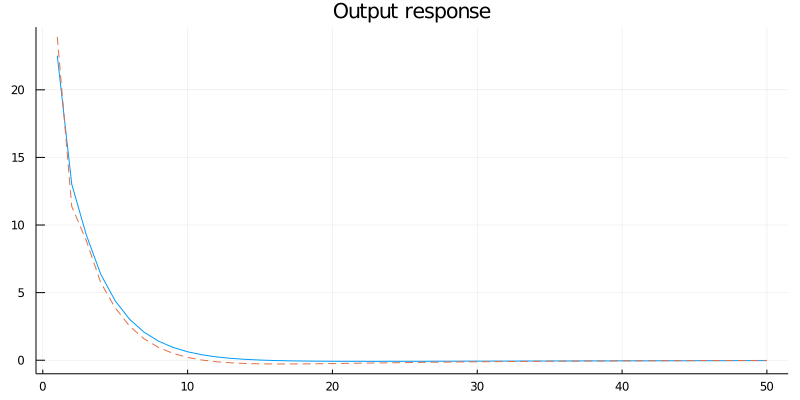

In [17]:
plot(10000*(vY[1:50] ./ dL_ss .- dL_ss), legend=:none)
plot!(10000*(vY_linear[1:50] ./ dL_ss .- dL_ss), ls=:dash)
title!("Output response")
plot!(size=(800,400))

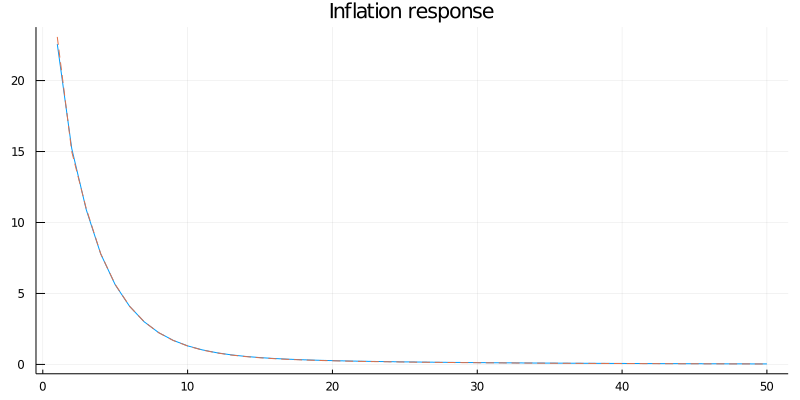

In [18]:
plot(10000*vPi[1:50], legend=:none)
plot!(10000*vPi_linear[1:50], ls=:dash)
title!("Inflation response")
plot!(size=(800,400))